In [159]:
%matplotlib inline
%reload_ext autoreload
%reload_ext snakeviz
%autoreload 2
%qtconsole

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
epoch_key = ('HPa', 6, 4)

In [4]:
from src.parameters import (ANIMALS, SAMPLING_FREQUENCY,
                            MULTITAPER_PARAMETERS, FREQUENCY_BANDS,
                            RIPPLE_COVARIATES)

In [5]:
from src.data_processing import (get_interpolated_position_dataframe,
                              get_LFP_dataframe,
                              get_mark_indicator_dataframe,
                              get_spike_indicator_dataframe,
                              make_neuron_dataframe,
                              make_tetrode_dataframe, reshape_to_segments,
                              save_xarray)
from src.ripple_decoding import (combined_likelihood,
                              estimate_marked_encoding_model,
                              estimate_sorted_spike_encoding_model,
                              estimate_state_transition, get_bin_centers,
                              predict_state, set_initial_conditions)


/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
tetrode_info = make_tetrode_dataframe(ANIMALS)[epoch_key]
mark_variables = ['channel_1_max', 'channel_2_max', 'channel_3_max',
                  'channel_4_max']
hippocampal_tetrodes = tetrode_info.loc[
    tetrode_info.area.isin(['CA1', 'iCA1']) &
    ~tetrode_info.descrip.str.endswith('Ref').fillna(False), :]

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)

marks = [(get_mark_indicator_dataframe(tetrode_key, ANIMALS)
          .loc[:, mark_variables])
         for tetrode_key in hippocampal_tetrodes.index]
marks = [tetrode_marks for tetrode_marks in marks
         if (tetrode_marks.loc[position_info.speed > 4, :].dropna()
             .shape[0]) != 0]

In [7]:
session_time = pd.cut(position_info.index, 3, labels=['early', 'middle', 'late'])
session_time

[early, early, early, early, early, ..., late, late, late, late, late]
Length: 1808237
Categories (3, object): [early < middle < late]

In [15]:
from src.analysis import (
    _get_place, _get_place_at_spike, _get_training_marks, get_bin_centers)

n_place_bins = 61
place_std_deviation=None
mark_std_deviation=20

train_position_info = position_info.loc[
    (session_time == 'early')  & (position_info.speed > 4)]
place = _get_place(train_position_info)
place_at_spike = [_get_place_at_spike(tetrode_marks,
                                      train_position_info)
                  for tetrode_marks in marks]
training_marks = [_get_training_marks(tetrode_marks,
                                      train_position_info,
                                      mark_variables)
                  for tetrode_marks in marks]

place_bin_edges = np.linspace(
    np.floor(position_info.linear_distance.min()),
    np.ceil(position_info.linear_distance.max()),
    n_place_bins + 1)
place_bin_centers = get_bin_centers(place_bin_edges)

if place_std_deviation is None:
    place_std_deviation = place_bin_edges[1] - place_bin_edges[0]

combined_likelihood_kwargs = estimate_marked_encoding_model(
    place_bin_centers, place, place_at_spike, training_marks,
    place_std_deviation=place_std_deviation,
    mark_std_deviation=mark_std_deviation)

state_transition = estimate_state_transition(
    train_position_info, place_bin_edges, sequence_compression_factor=1)

state_names = ['outbound_forward',
               'inbound_forward']
n_states = len(state_names)
initial_conditions = set_initial_conditions(
    place_bin_edges, place_bin_centers, n_states)

decoder_kwargs = dict(
    initial_conditions=initial_conditions,
    state_transition=state_transition,
    likelihood_function=combined_likelihood,
    likelihood_kwargs=combined_likelihood_kwargs
)


In [9]:
test_position_info = position_info.loc[
    (session_time == 'early')  & (position_info.speed > 4)]

In [10]:
ripple_marks = np.stack([mark.loc[test_position_info.index] for mark in marks], axis=1)

In [11]:
test_data = xr.DataArray(ripple_marks, dims=['time', 'tetrode', 'marks'], coords={
    'time': test_position_info.index,
    'tetrode': np.arange(len(hippocampal_tetrodes)),
    'marks': np.arange(4) + 1
})

test_spikes = 1 * (~test_data.mean('marks').isnull())

In [39]:
posterior_density = xr.DataArray(
    predict_state(ripple_marks, **decoder_kwargs).reshape((-1, n_states, place_bin_centers.size)),
    dims=['time', 'state', 'linear_position'],
    coords={
         'time': test_position_info.index,
         'linear_position': place_bin_centers,
         'state': state_names
    }
)

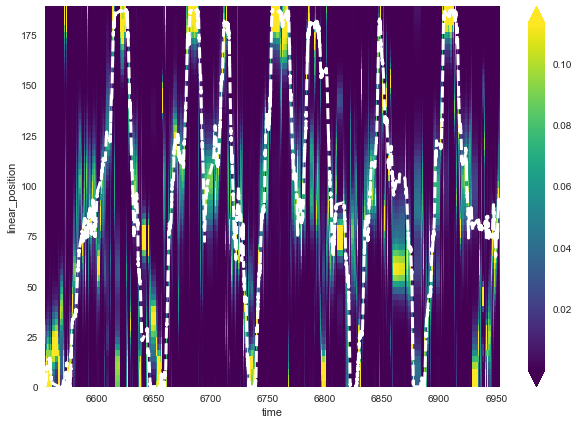

In [41]:
g = posterior_density.sum('state').plot(x='time', y='linear_position', robust=True, size=7)
test_position_info.linear_distance.plot(ax=g.axes, color='white', linestyle='--', linewidth=3);

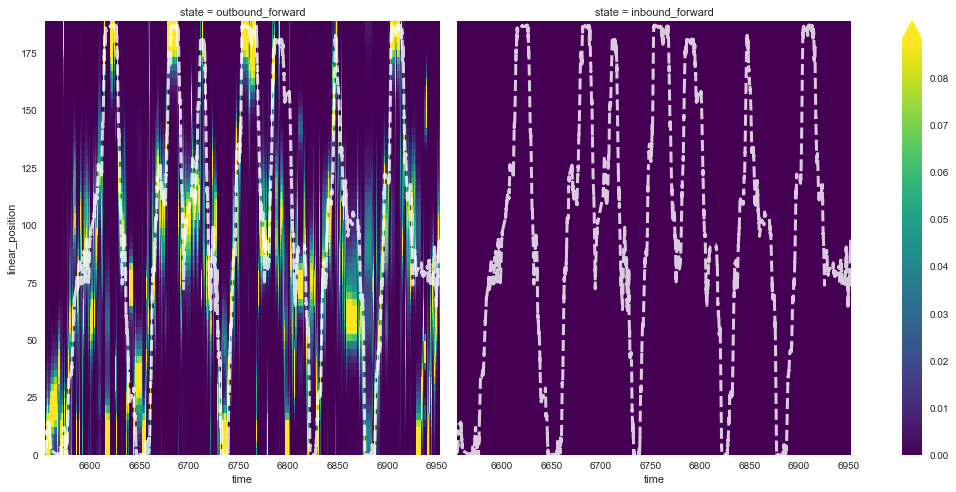

In [26]:
g = posterior_density.plot(x='time', y='linear_position', col='state', col_wrap=2, size=7, robust=True)
for ax in g.axes.ravel().tolist():
    test_position_info.linear_distance.plot(ax=ax, color='white', linestyle='--', linewidth=3, alpha=0.8);

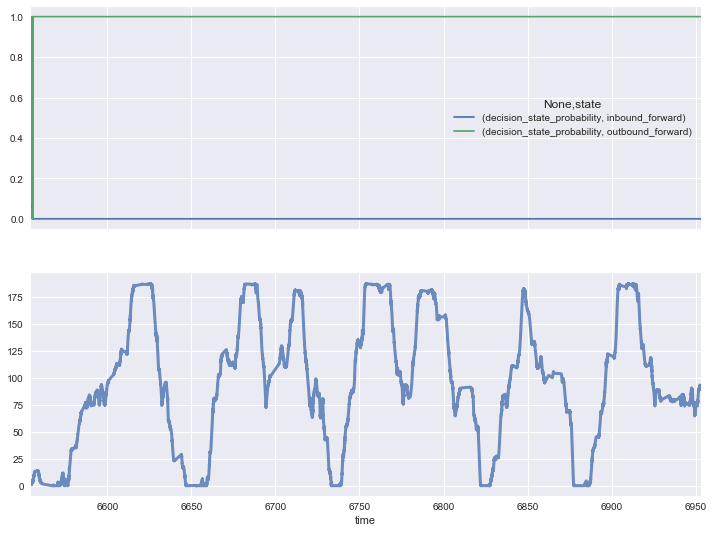

In [40]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 9))
posterior_density.sum('linear_position').to_dataframe(name='decision_state_probability').unstack().plot(ax=ax[0]);
test_position_info.linear_distance.plot(ax=ax[1], linewidth=3, alpha=0.8);

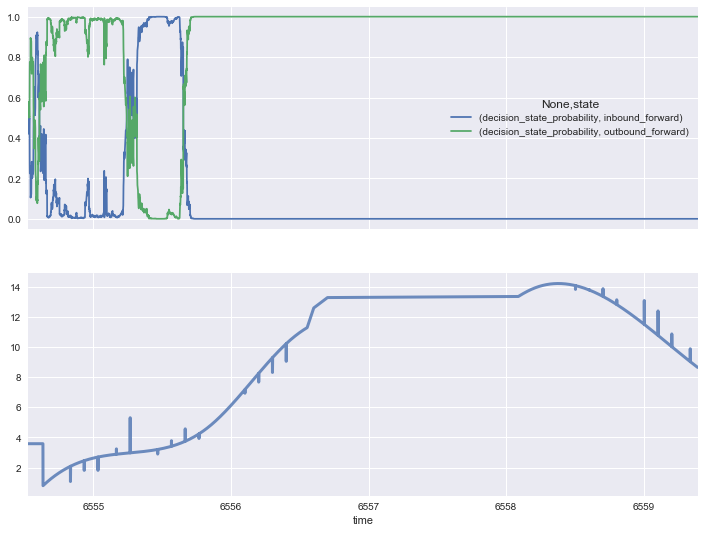

In [49]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 9))
posterior_density.isel(time=slice(0, 5000)).sum('linear_position').to_dataframe(name='decision_state_probability').unstack().plot(ax=ax[0]);
test_position_info.iloc[slice(0, 5000)].linear_distance.plot(ax=ax[1], linewidth=3, alpha=0.8);

In [13]:
test_position_info = position_info.loc[
    (session_time == 'middle')  & (position_info.speed > 4)]

In [14]:
ripple_marks = np.stack([mark.loc[test_position_info.index] for mark in marks], axis=1)

In [17]:
posterior_density = xr.DataArray(
    predict_state(ripple_marks, **decoder_kwargs).reshape((-1, n_states, place_bin_centers.size)),
    dims=['time', 'state', 'linear_position'],
    coords={
         'time': test_position_info.index,
         'linear_position': place_bin_centers,
         'state': state_names
    }
)

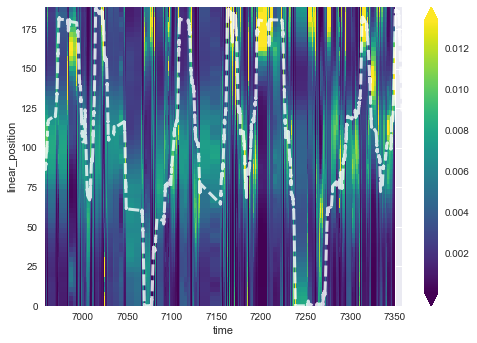

In [18]:
g = posterior_density.mean('state').plot(x='time', y='linear_position', robust=True)
test_position_info.linear_distance.plot(ax=g.axes, color='white', linestyle='--', linewidth=3, alpha=0.8);

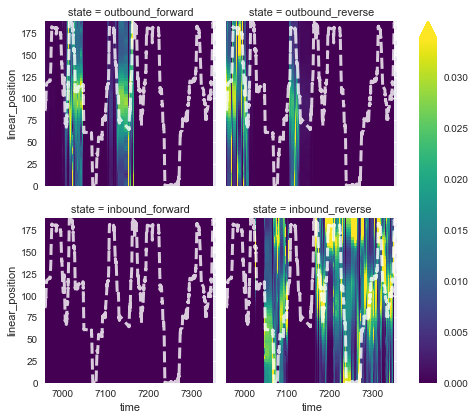

In [21]:
g = posterior_density.plot(x='time', y='linear_position', robust=True, col='state', col_wrap=2)
for ax in g.axes.ravel().tolist():
    test_position_info.linear_distance.plot(ax=ax, color='white', linestyle='--', linewidth=3, alpha=0.8);

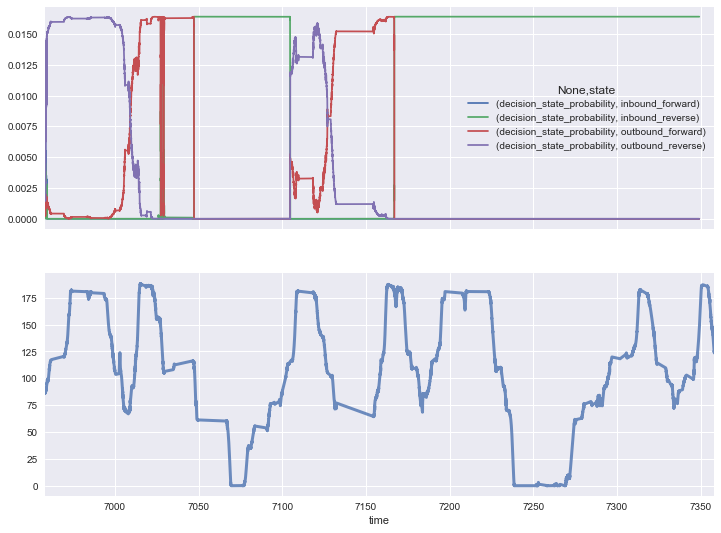

In [36]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 9))
posterior_density.mean('linear_position').to_dataframe(name='decision_state_probability').unstack().plot(ax=ax[0]);
test_position_info.linear_distance.plot(ax=ax[1], linewidth=3, alpha=0.8);

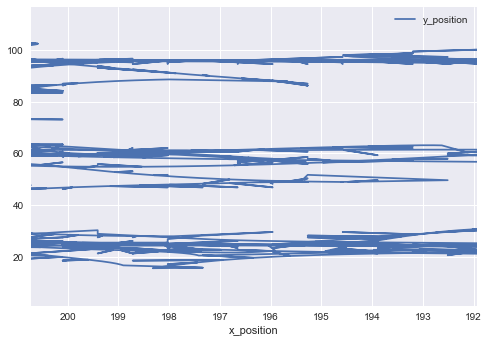

In [45]:
test_position_info.plot(x='x_position', y='y_position')

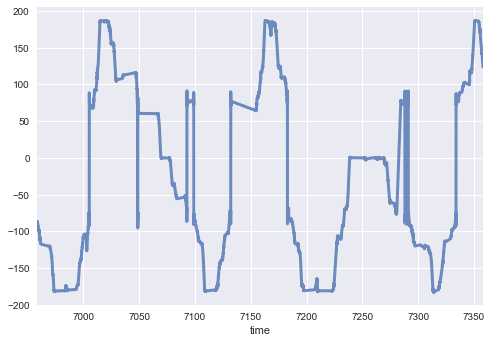

In [41]:
test_position_info.linear_position.plot(linewidth=3, alpha=0.8);